Try to compute DCR for a given SED.

First, we'll use the code that generates Figure 2 in the paper.

Let's tweak it so we can try to use the supernova spectrum.

This is a mod. of chroma_test2 where we're going to play with estimating the DCR for a SN Ia along its light curve.

In [2]:
import os
import numpy as np

import dcr
import spec    ## dont forget to add $HOME/GIT_REPOS/chroma/chroma to PYTHONPATH before starting ipython notebook
#import plot
#import utils

#import _mypath
#import chroma

datadir = '/Users/dreiss/GIT_REPOS/chroma/data/'

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.style.use('ggplot')

## see http://matplotlib.org/users/colormaps.html for colormaps
from matplotlib import cm

In [4]:
import pandas as pd

## see: https://stackoverflow.com/questions/19536817/manipulate-html-module-font-size-in-ipython-notebook
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

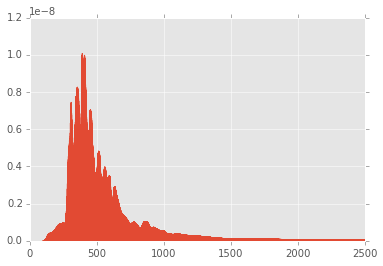

In [3]:
from scipy.interpolate import interp1d

tmp,w,f = np.genfromtxt(datadir+'SEDs/snflux_1a.dat').T
w /= 10. ## convert from angstroms to nm?
ss = interp1d(w, f)

sn_SED = spec.SED(ss)
wave = np.arange(500.0, 901.0, 1.0)
photons = sn_SED(wave)

plt.plot(ss.x, ss.y)

Aha, the SN Ia spec is multiple spectra - let's extract all of them and set to $z=0.5$ (first few look weird).

In [4]:
#print np.where(w == w.max())[0]
sn_SEDs = []
val_prev = 0
for ind,val in enumerate(np.where(w == w.max())[0]):
    #print ind,val
    ww = w[val_prev:val]
    ff = f[val_prev:val]
    ss = interp1d(ww, ff)
    sed = spec.SED(ss).atRedshift(0.5)
    sn_SEDs.append(sed)
    val_prev = val + 1

print len(sn_SEDs) 
#plt.plot(w[252105:254506], f[252105:254506])

106


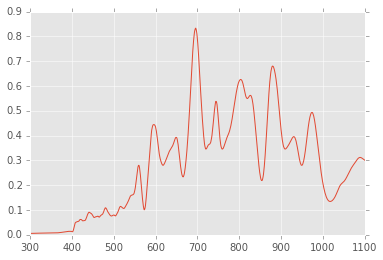

In [5]:
sn_SED = sn_SEDs[100] #spec.SED(ss).atRedshift(0.5)
wave = np.arange(300.0, 1101.0, 1.0)
photons = sn_SED(wave)

scale = 1.2 * photons[(wave > 500) & (wave < 900)].max()
plt.plot(wave, photons/scale)

Looks like spec has a few useful functions like 

```
calculateDCRMomentShifts(self, bandpass, **kwargs):
```

        @returns a tuple.  The first element is the vector of DCR first moment shifts, and the
                 second element is the 2x2 matrix of DCR second (central) moment shifts.


Sa galaxy at redshift 0.5

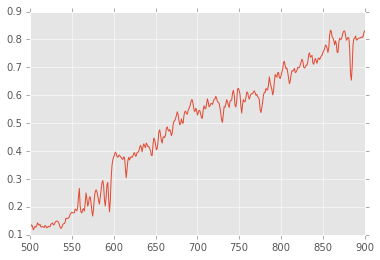

In [6]:
#gal_SED = spec.SED(datadir+'/SEDs/'+'KIN_Sa_ext.ascii')
w,f = np.genfromtxt(datadir+'SEDs/KIN_Sa_ext.ascii').T
#toAppend = np.arange(w.max()+0.5,1200.,0.5)
#w = np.append(w, toAppend)
#f = np.append(f, np.zeros_like(toAppend))
ss = interp1d(w, f)

gal_SED = spec.SED(ss).atRedshift(0.5)
wave = np.arange(500.0, 901.0, 1.0)
photons = gal_SED(wave)

scale = 1.2 * photons[(wave > 500) & (wave < 1000)].max()
plt.plot(wave, photons/scale)

Make a relative DCR curve for SN Ia along its light curve (assume ZD angle 20 deg.)

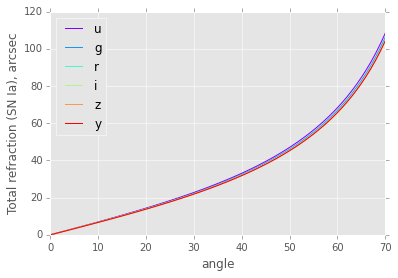

In [7]:
# filters are stored in two columns: wavelength (nm), and throughput

def compute_dcr(SED, filters='ugrizy', angles=np.linspace(0,70,71), relative=None, **kwargs):
    if type(angles) is int or type(angles) is float:
        angles = np.array([angles])
    elif type(angles) is list:
        angles = np.array(angles)        
    if type(filters) is int or type(filters) is float:
        filters = np.array([filters])
    df = pd.DataFrame(pd.Series(angles)) #, index=pd.Series(angles))
    for i, filter_ in enumerate(filters):
        if type(filter_) is str:
            fdata = spec.Bandpass(datadir+'filters/LSST_{}.dat'.format(filter_))
            fwave, throughput = fdata.wave_list, fdata(fdata.wave_list)
            shifts = np.array( [SED.calculateDCRMomentShifts(fdata, zenith_angle=angle * np.pi/180.0, **kwargs)[0].item(1) 
                            for angle in angles])
            shifts = shifts * 3600.0 * 180.0/np.pi            
            df = pd.concat([df, pd.Series(shifts)], axis=1, ignore_index=True)
        else: # assume it's a single wavelength value (nm) then
            shifts = np.array( [dcr.get_refraction(filter_, zenith=angle * np.pi/180.0, **kwargs) for angle in angles])
            shifts = shifts * 3600.0 * 180.0/np.pi            
            df = pd.concat([df, pd.Series(shifts)], axis=1, ignore_index=True)
             
    df.columns = np.insert(np.array(list(filters), dtype='S6'), 0, 'angle')
    df = df.set_index('angle')
    if relative is not None and np.any(df.columns.values == relative):
        df2 = df.copy().sub(df[relative], axis=0)
        return df2
    else:
        return df

angles = np.linspace(0,70,71)

DCRs = compute_dcr(sn_SED, 'ugrizy', angles)
ax = DCRs.plot(colormap=cm.rainbow)
ax.set_ylabel('Total refraction (SN Ia), arcsec')

#DCRs = compute_dcr(sn_SED, 'ugrizy', angles, relative='r')
#ax = DCRs.plot(colormap=cm.rainbow)
#ax.set_ylabel('Relative refraction, arcsec')

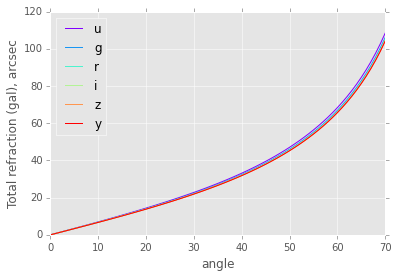

In [8]:
DCRs_gal = compute_dcr(gal_SED, 'ugrizy', angles)
ax = DCRs_gal.plot(colormap=cm.rainbow)
ax.set_ylabel('Total refraction (gal), arcsec')

#DCRs_gal = compute_dcr(gal_SED, 'ugrizy', angles, relative='r')
#ax = DCRs_gal.plot(colormap=cm.rainbow)
#ax.set_ylabel('Relative refraction, arcsec')

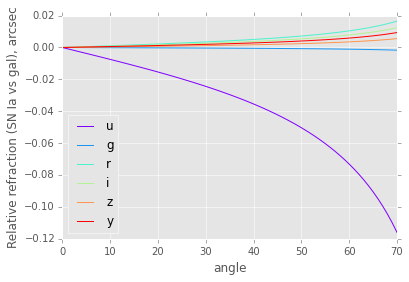

In [9]:
df_tmp = DCRs - DCRs_gal
sizeme(df_tmp.head())
ax = df_tmp.plot(colormap=cm.rainbow)
ax.set_ylabel('Relative refraction (SN Ia vs gal), arcsec')

In [10]:
sizeme(compute_dcr(sn_SED, 'ugrizy', 20.))

,u,g,r,i,z,y
angle,,,,,,
20,14.356802,14.06186,13.925262,13.862969,13.826746,13.807054


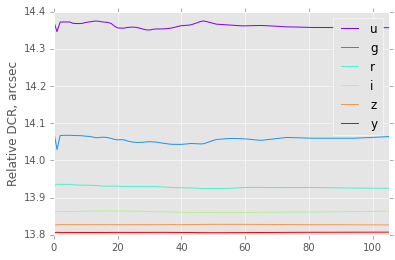

In [11]:
#sn_DCRs = pd.concat([compute_dcr(SED, 'ugrizy', 20., relative='r') for SED in sn_SEDs])
sn_DCRs = pd.concat([compute_dcr(SED, 'ugrizy', 20.) for SED in sn_SEDs])
sn_DCRs = sn_DCRs.set_index(np.arange(len(sn_SEDs)))
gal_DCR = compute_dcr(gal_SED, 'ugrizy', 20.)
ax = sn_DCRs.plot(colormap=cm.rainbow)
ax.set_ylabel('Relative DCR, arcsec')
#sizeme(sn_DCRs)

DCR of SN Ia along light curve at zenith angle of 20 deg. as a function of time:

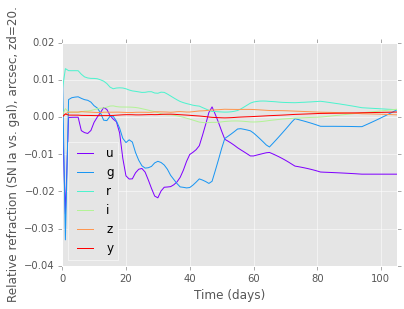

In [12]:
sn_DCRs = pd.concat([compute_dcr(SED, 'ugrizy', 20.) for SED in sn_SEDs])
sn_DCRs = sn_DCRs.set_index(np.arange(len(sn_SEDs)))
gal_DCR = compute_dcr(gal_SED, 'ugrizy', 20.)

tmp_df = sn_DCRs - gal_DCR.values.squeeze()
ax = tmp_df.plot(colormap=cm.rainbow)
ax.set_ylabel('Relative refraction (SN Ia vs. gal), arcsec, zd=20.')
ax.set_xlabel('Time (days)')

Try it at zenith angle 40 deg. - doesn't seem to differ much from 20 deg.

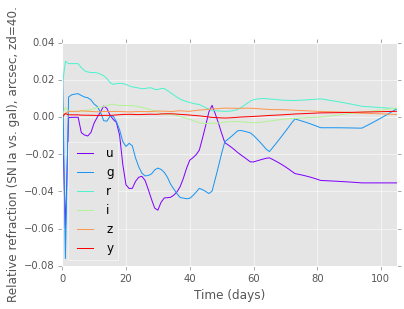

In [27]:
sn_DCRs = pd.concat([compute_dcr(SED, 'ugrizy', 40.) for SED in sn_SEDs])
sn_DCRs = sn_DCRs.set_index(np.arange(len(sn_SEDs)))
gal_DCR = compute_dcr(gal_SED, 'ugrizy', 40.)

tmp_df = sn_DCRs - gal_DCR.values.squeeze()
ax = tmp_df.plot(colormap=cm.rainbow)
ax.set_ylabel('Relative refraction (SN Ia vs. gal), arcsec, zd=40.')
ax.set_xlabel('Time (days)')

Investigate other aspects like temp. and pressure. 
See [here](https://project.lsst.org/groups/sites/lsst.org.groups.safety/files/LSST%20Summit%20Environmental%20Conditions%20Requirements%2003-11.pdf)...

Table 2: Normal Conditions in which LSST is required to meet the specifications
    Parameter Operational requirement
    ---------
    Temperature Range -3 ºC to +19ºC (27°F to 66°F) (mean 11.5degC)
    Temperature Gradient 0.7C /hr
    Relative Humidity The maximum relative humidity (non condensing) is 90%
    The mean relative humidity (non condensing) is 40%
    Wind Speed Wind speed < 12 m/sec
    Barometric Pressure 749.3 mbar 

How many kPa in 1 mm Hg? The answer is 0.13332239.
How many millibar in 1 kilopascal? The answer is 10.

    Arguments
    ---------
    wave -- wavelength in nanometers
    pressure -- in kiloPascals (default 69.328 kPa = 520 mmHg)
    temperature -- in Kelvin (default 293.15 kPa = 20 C)
    H2O_pressure -- in kiloPascals (default 1.067 kPa = 8 mmHg)


In [70]:
print 69.328/0.13332239
print 749.3/10./0.13332239
print
print dcr.air_refractive_index(600.)
print dcr.air_refractive_index2(600.)
print
print dcr.get_refraction(600., 20. * np.pi/180.0, pressure=69.328, temperature=293.15, H2O_pressure=1.067)  * 3600.0 * 180.0/np.pi
print dcr.get_refraction(600., 20. * np.pi/180.0, pressure=69.328, temperature=293.15-3., H2O_pressure=1.067)  * 3600.0 * 180.0/np.pi
print dcr.get_refraction(600., 20. * np.pi/180.0, pressure=69.328, temperature=293.15+19., H2O_pressure=1.067)  * 3600.0 * 180.0/np.pi
print
print compute_dcr(gal_SED, filters=600., angles=20., temperature=293.15).ix[20][0]
print compute_dcr(gal_SED, filters=600., angles=20., temperature=293.15-3.).ix[20][0]
print compute_dcr(gal_SED, filters=600., angles=20., temperature=293.15+19.).ix[20][0]
print
print compute_dcr(gal_SED, filters='r', angles=20., temperature=293.15).ix[20][0]
print compute_dcr(gal_SED, filters='r', angles=20., temperature=293.15-3.).ix[20][0]
print compute_dcr(gal_SED, filters='r', angles=20., temperature=293.15+19.).ix[20][0]
print
print compute_dcr(gal_SED, filters='r', angles=20., temperature=293.15).ix[20][0]


520.00267922
562.021127884

1.00018577948
1.00018582692

13.9433693327
14.0878418669
13.0928475368

13.9433693327
14.0878418669
13.0928475368

13.9230696816
14.0673319459
13.0737857861

13.9230696816


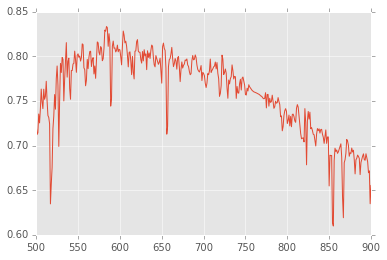

In [6]:
from scipy.interpolate import interp1d

#gal_SED = spec.SED(datadir+'/SEDs/'+'KIN_Sa_ext.ascii')
w,f = np.genfromtxt(datadir+'SEDs/ukg5v.ascii').T
#toAppend = np.arange(w.max()+0.5,1200.,0.5)
#w = np.append(w, toAppend)
#f = np.append(f, np.zeros_like(toAppend))
ss = interp1d(w, f)

gal_SED = spec.SED(ss)
wave = np.arange(500.0, 901.0, 1.0)
photons = gal_SED(wave)

scale = 1.2 * photons[(wave > 500) & (wave < 1000)].max()
plt.plot(wave, photons/scale)